In [ ]:
!pip install boto3

In [ ]:
from PIL import Image

In [ ]:
dir_path = "/content/drive/MyDrive/pillow_image_files"
img1 = Image.open(dir_path+"/쵸단1.png")
img2 = Image.open(dir_path+"/쵸단2.png")
img3 = Image.open(dir_path+"/츄정1.png")
img4 = Image.open(dir_path+"/한지민.jpeg")

In [ ]:
frame1 = Image.open(dir_path + "/frame1.png")
frame2 = Image.open(dir_path + "/frame2.png")
frame3 = Image.open(dir_path + "/frame3.png")
frame4 = Image.open(dir_path + "/frame4.png")

In [ ]:
input = 'frame1'
frame_num = int(input[5:])
frame_num

1

In [ ]:
frame_coordinate = {1:[34,323,110,473],2:[34,323,110,473]}
frame_inner_size = {1: (260,340),2:(260,340)}

In [ ]:
x1,x2,y1,y2 = frame_coordinate[frame_num]

In [ ]:
inner_size = frame_inner_size[frame_num]

In [ ]:
resize_img1 = img1.resize(inner_size)
resize_img2 = img2.resize(inner_size)
resize_img3 = img3.resize(inner_size)
resize_img4 = img4.resize(inner_size)

In [ ]:
copy_empty_frame = frame1.copy()
copy_empty_frame.paste(resize_img1,(x1,y1))
copy_empty_frame.paste(resize_img2,(x2,y1))
copy_empty_frame.paste(resize_img3,(x1,y2))
copy_empty_frame.paste(resize_img4,(x2,y2))

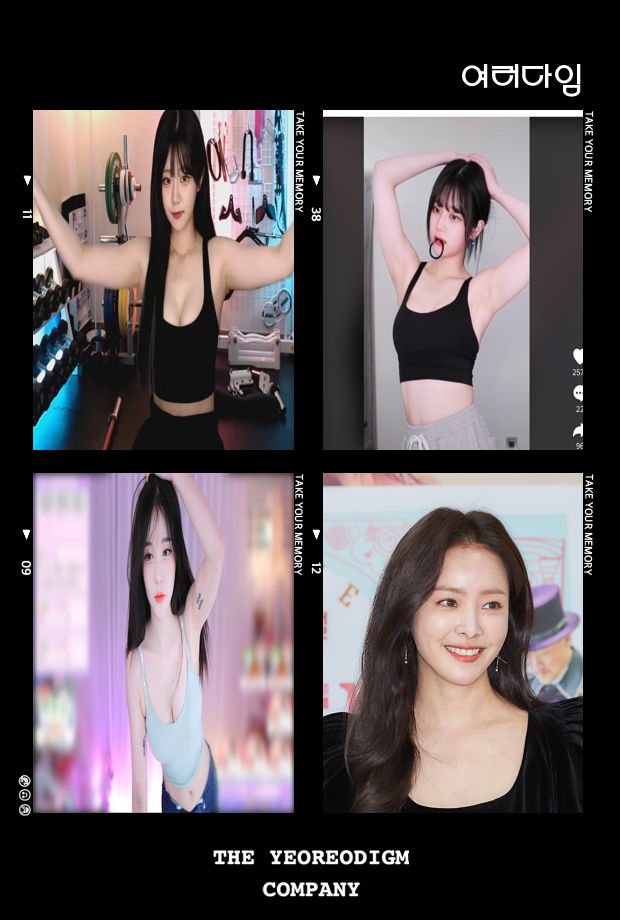

In [ ]:
display(copy_empty_frame)

In [ ]:
# 사진 크기 
# 510 x 408 

# 위치
# 46 100
# 651 515

In [ ]:
100 + 408 + 6

514

In [ ]:
frame_coordinate = {1:(34,323,110,473),2:(34,323,110,473),3:(47,651,100,515),4:(47,651,100,515)}
frame_inner_size = {1: (260,340),2:(260,340),3:(509,409),4:(509,409)}
frame_num = int(frame[5:])

In [ ]:
x1,x2,y1,y2 = frame_coordinate[frame_num]
inner_size = frame_inner_size[frame_num]

In [ ]:
resize_img1 = img1.resize(inner_size)
resize_img2 = img1.resize(inner_size)
resize_img3 = img3.resize(inner_size)
resize_img4 = img4.resize(inner_size)

In [ ]:
empty_frame4 = frame4.copy()
empty_frame4.paste(resize_img1,(x1,y1))
empty_frame4.paste(resize_img2,(x2,y1))
empty_frame4.paste(resize_img3,(x1,y2))
empty_frame4.paste(resize_img4,(x2,y2))

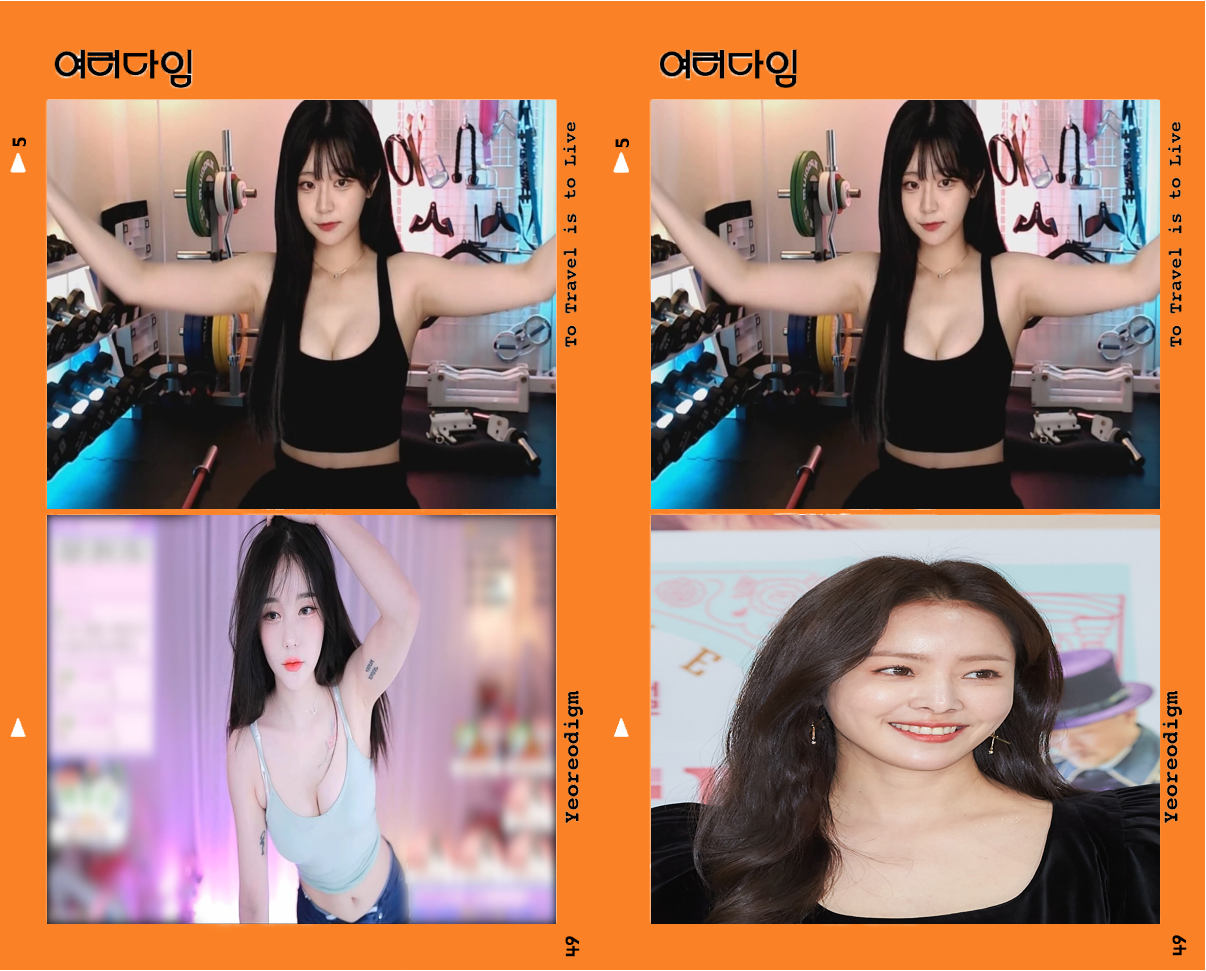

In [ ]:
display(empty_frame4)

###Lambda 수정

In [1]:
import json
from PIL import Image
import boto3
import psycopg2
import os
import io

prefix_info = {
  'image' : "assets/photoDigm/userPicture/",
  'frame' : "assets/photoDigm/frame/",
  'photoDigm' : "assets/photoDigm/photoDigm/",
}

frame_coordinate = {1:(34,323,110,473),2:(34,323,110,473),3:(47,651,100,515),4:(47,651,100,515)}
frame_inner_size = {1: (260,340),2:(260,340),3:(509,409),4:(509,409)}

def connect_s3():
  with open("/content/drive/MyDrive/yeoreodigm/data_files/aws_access_info.json") as f:
    aws_access_info = json.load(f)
  return boto3.client('s3',aws_access_key_id=aws_access_info['AWS_ACCESS_KEY_ID'],
                                  aws_secret_access_key=aws_access_info['AWS_SECRET_ACCESS_KEY'],
                                  region_name=aws_access_info['REGION_NAME'])
    
#img_type : frame,image,photoDigm
def load_image(client,img_type,file_name):
  bucket_name = "yeoreodigm-s3"
  prefix = prefix_info[img_type]

  
  entire_path = prefix + file_name  #디렉토리 경로를 모두 포함한 파일 경로
  result = client.list_objects(Bucket = bucket_name, Prefix=entire_path)

  for obj in result.get('Contents'):
    data = client.get_object(Bucket=bucket_name,Key=obj.get('Key'))
    data_content = data['Body'].read()
    #display(Image.open(io.BytesIO(data_content)))
    return Image.open(io.BytesIO(data_content))
    
    
    
def lambda_handler(event, context):
  # TODO implement
  img1 = event['img1']
  img2 = event['img2']
  img3 = event['img3']
  img4 = event['img4']
  frame = event['frame']
  key = event['key']
  
  frame_num = int(frame[5:])

  x1,x2,y1,y2 = frame_coordinate[frame_num]
  inner_size = frame_inner_size[frame_num]

  
  client = connect_s3()
  
  try:
    frame_img = load_image(client=client,img_type='frame',file_name=frame) 
    img1 = load_image(client=client,img_type='image',file_name=img1).resize(inner_size)
    img2 = load_image(client=client,img_type='image',file_name=img2).resize(inner_size)
    img3 = load_image(client=client,img_type='image',file_name=img3).resize(inner_size)
    img4 = load_image(client=client,img_type='image',file_name=img4).resize(inner_size)
  except:
      return {
      'statusCode': 400,
      'body': json.dumps('Failed to Load Image from s3!'),

  }
  
  frame_img.paste(img1,(x1,y1))
  frame_img.paste(img2,(x2,y1))
  frame_img.paste(img3,(x1,y2))
  frame_img.paste(img4,(x2,y2))
  
  mem_out = io.BytesIO()
  frame_img.save(mem_out,format=frame_img.format) # binary data를 BytesIO로 변환해서 memout에 담기
  mem_out.seek(0)#파일포인터(?) 복구
  bucket_name = 'yeoreodigm-s3'
  save_path = prefix_info['photoDigm'] + key
  client.upload_fileobj(mem_out,bucket_name,save_path,ExtraArgs={'ContentType':"image/png"})
  
  return {
      'statusCode': 200,
      'body': json.dumps('Hello from Lambda!'),
      
      
      
  }


ModuleNotFoundError: ignored